In [1]:
import numpy as np
import os
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import sys
sys.path.append('/content/gdrive/My Drive/aleksander_petuskey_proj4')

# Part 1: Nose Tip Detection

For the first part, we will use the IMM Face Database available on this website for training an initial toy model for nose tip detection. The dataset has 240 facial images of 40 persons and each person has 6 facial images in different viewpoints. All images are annotated with 58 facial keypoints. Please use all 6 images of the first 32 persons (index 1-32) as the training set (total 32 x 6 = 192 images) and the images of the remaining 8 persons (index 33-40) (8 * 6 = 48 images) as the validation set. As a reference, the staff solution takes less than 1 minute to train 10 epoches locally.
We will cast the nose detection problem as a pixel coordinate regression problem, where the input is a single grayscale image, and the outputs are the nose tip positions (x, y). In practice, (x, y) are represented as the ratio of image width and height, ranging from 0 to 1.



In [ ]:
from datahelpers import FaceLoader, FaceLoaderTransform

def showing(smp, p=None, sz=6, title=None):
    im = smp['im']
    lm = smp['lm']
    
    result = np.zeros(lm.shape)
    for i in range(len(result)):
        result[i, :] = im.shape[1] * lm[i, 0], im.shape[0] * lm[i, 1]
    lm = result
    
    if not p:
        p = plt
    p.axis("off")
    p.imshow(im, cmap='gray'), p.scatter(lm[:, 0], lm[:, 1], s = sz)
    if title:
        p.set_title(title)
        
def relays_1d(im, lm):
    return np.array([lm[0] * im.shape[1], lm[1] * im.shape[0]])


# Results Dataloader

Use the dataloader from torch.utils.data.DataLoader. This tutorial shows how to write a custom dataloader. You need to load both the images and the keypoints - you may be able to reuse code from Project 3. Then, you need to convert the image into grayscale and convert image pixel values in uint8 from 0 to 255, to normalized float values in range -0.5 to 0.5 (image.astype(np.float32) / 255 - 0.5). After that, resize the image into smaller size, e.g., 80x60. For loading the facial keypoints including the nose keypoint, we have provided example code. Once you have the dataloader, sample a few images and display them along with the nose keypoints. 

## Sampled image from your dataloader visualized with ground-truth keypoints.

In [ ]:
from transformations import Transformation, Rescale, Rotate, Shift, FlipX
dataset = FaceLoader(trans=Rescale((80, 60)))

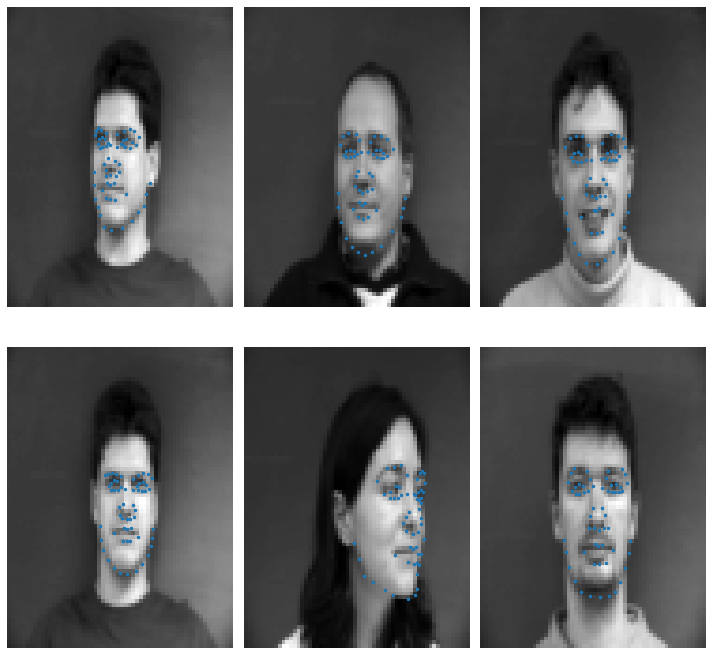

In [ ]:
f, axs = plt.subplots(2, 3, figsize=(10, 10))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(dataset))
        res = dataset[idx]
        showing(res, axs[i, j])
f.tight_layout()

In [ ]:
dataset = FaceLoader(trans=Rescale((80, 60)), landmarks=[-6])

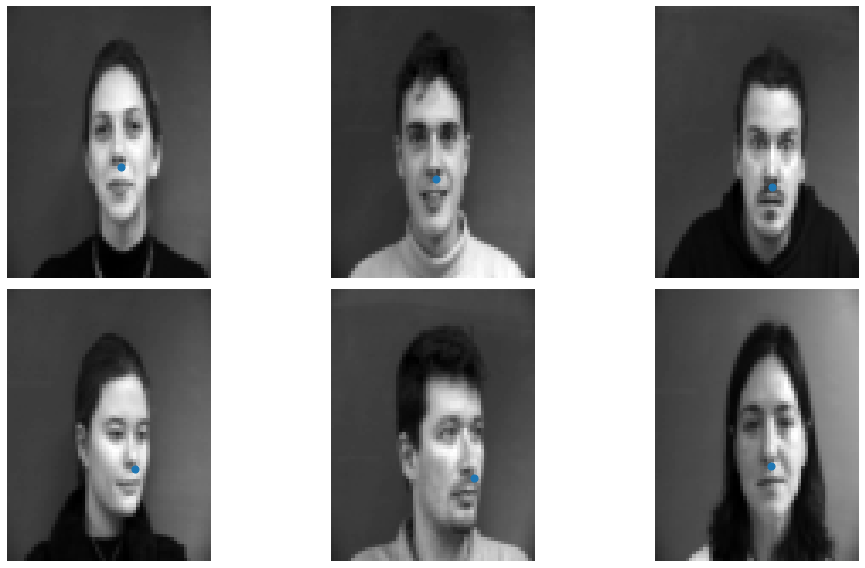

In [ ]:
f, axs = plt.subplots(2, 3, figsize=(15, 8))
for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(dataset))
        res = dataset[idx]
        showing(res, axs[i, j], sz=50)
f.tight_layout()

# CNN
Once you have the dataloader, write a convolutional neural network using torch.nn.Module. This tutorial gives an example of how to write a neural network in PyTorch. If you are not familiar with PyTorch or CNN architectures, please refer to this tutorial. Our CNNs will use a convolutional layer (torch.nn.Conv2d), max pooling layer (torch.nn.MaxPool2d) and Rectilinear Unit as non-linearity (torch.nn.ReLU). The architecture of your neural network should be 3-4 convolutional layers, 12-32 channels each. The kernel/filter size for each convolutional layer should be 7x7, 5x5 or 3x3. Each convolutional layer will be followed by a ReLU followed by a maxpool. Finally, this should be followed by 2 fully connected layers. Apply ReLU after the first fully connected layer (but not after the last fully connected layer). You should play around with different design choices to improve your result. 

In [ ]:
from conv import ConvNet
chan_list = [1, 12, 16, 16, 32]
kern_sizes = [7, 5, 5, 3]
pool_sizes = [2, 2, 2, 2]

In [ ]:
dataset = FaceLoader(trans=Rescale((90, 60)), landmarks=[-6],)
eval_dataset = FaceLoader(trans=Rescale((90, 60)), evl = True, landmarks=[-5])
im = dataset[0]['im']
net = ConvNet(chan_list, kern_sizes, pool_sizes, [120, 84, 2], im.shape, s=1, learn=1e-4)
dl = DataLoader(dataset, batch_size=32, shuffle=True)
dl_evl = DataLoader(eval_dataset, batch_size = 16, shuffle=False)
losses = net.run_training_loop(dl, dl_evl,20)

GPU not detected. Defaulting to CPU.


## Examine the results

Plot the train and validation accuracy during the training process.



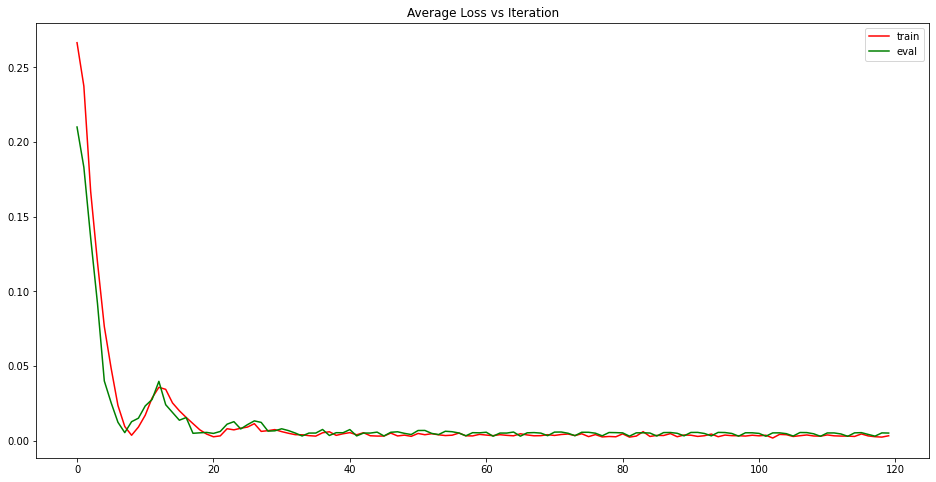

In [ ]:
tl, el = losses
plt.figure(figsize=(16, 8))
plt.plot(tl, label='train', c ='r')
plt.plot(el, label='eval', c='g')
plt.title("Average Loss vs Iteration")
plt.legend()
plt.show()

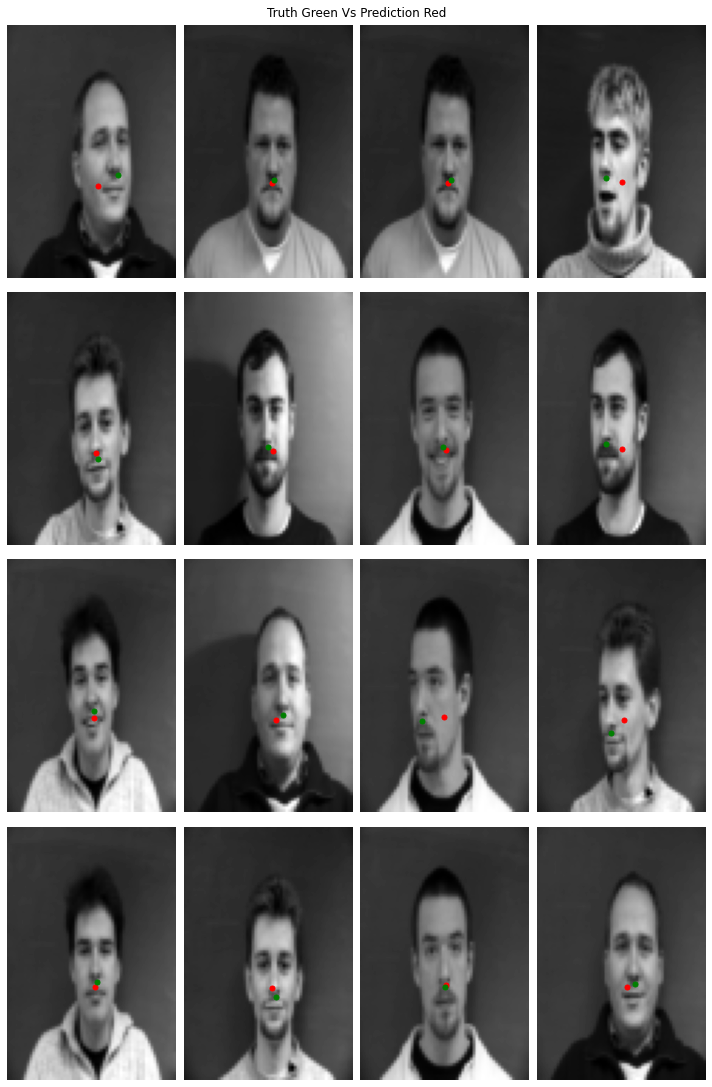

In [ ]:
def from_numpy(*args, **kwargs):
    return torch.from_numpy(*args, **kwargs).float().to(device)

def to_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

def nosepoints(dataset, net, i, p=None, sz=25):
    sample = dataset[i]
    im = sample['im']
    unsqz_im, tgt = from_numpy(im)[None][None], sample['lm'][0]
    pred = to_numpy(net.forward(unsqz_im))[0]
    ac_pred, ac_tgt = relays_1d(im, pred), relays_1d(im, tgt)
    if p:
        p.imshow(im, cmap='gray'), p.axis('off')
        p.scatter(ac_pred[0], ac_pred[1], c = 'r', s=sz)
        p.scatter(ac_tgt[0], ac_tgt[1], c= 'g', s=sz)
    return np.linalg.norm(ac_pred - ac_tgt)


f, axs = plt.subplots(4, 4, figsize=(10, 15))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        idx = np.random.randint(len(eval_dataset))
        nosepoints(dataset, net, idx, p=axs[i][j])

plt.suptitle("Truth Green Vs Prediction Red", y=1.005, fontsize=12)
f.tight_layout() 

Show 2 facial images which the network detects the nose correctly, and 2 more images where it detects incorrectly. Explain why you think it fails in those cases.

In [ ]:
lst_eval = []
for i in range(len(eval_dataset)):
    loss = nosepoints(eval_dataset, net, i)
    lst_eval.append((loss, i))

lst_eval = sorted(lst_eval, key=lambda x: x[0])


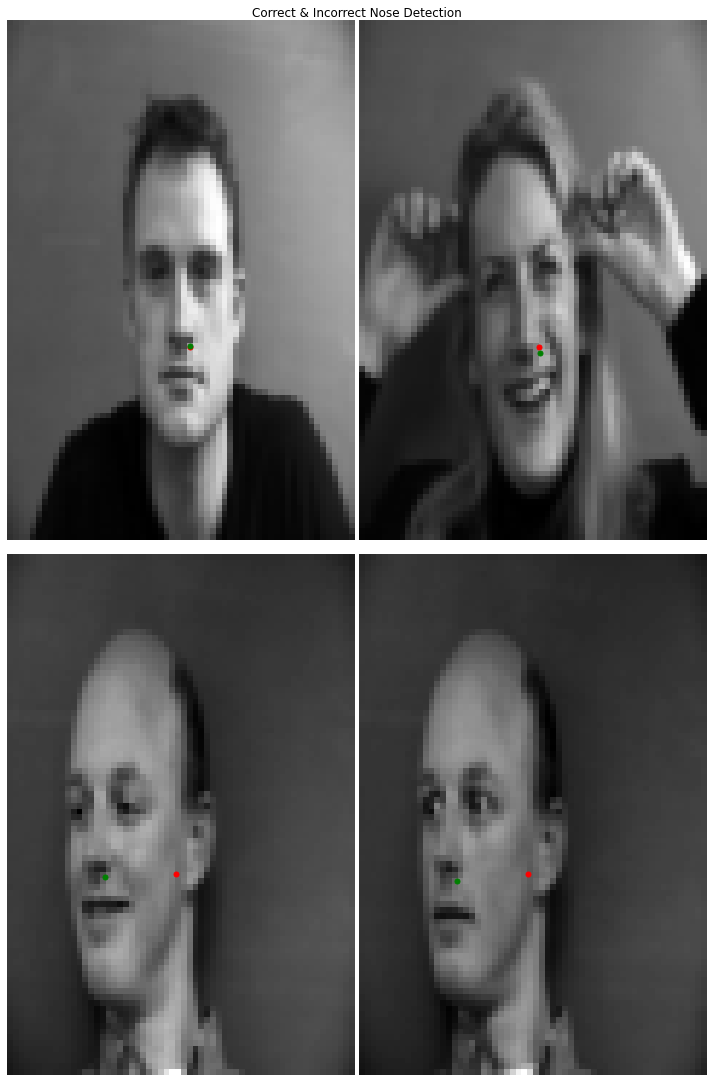

In [ ]:
lst = [0, 1, -1, -2]
cntr = 0
f, axs = plt.subplots(2, 2, figsize=(10, 15))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        nosepoints(eval_dataset, net, lst_eval[lst[cntr]][1], p=axs[i][j])
        cntr += 1

plt.suptitle("Correct & Incorrect Nose Detection", y=1, fontsize=12)
f.tight_layout() 


# Part 2: Full Facial Keypoints Detection

We are not satisfied with just detecting the nose tip position - in this section we want to move forward and detect all 58 facial keypoints/landmarks. You need to use the same dataset as Part 1 but now try to load all 58 keypoints and predict them.

In [ ]:
from __future__ import print_function, division
import os
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import warnings
warnings.filterwarnings("ignore")

# Dataloader 

The code in this section should be similar to part 1, but this time, try a larger input image size like 160x120 or 240x180. Since it is a small dataset, we will also need data augmentation to prevent the trained model from overfitting. Check this tutorial to learn more about data augmentation in PyTorch. There are many ways to perform data augmentation, including randomly changing the brightness and saturation of the resized face (torchvision.transforms.ColorJitter), randomly rotating the face for like -15 to 15 degrees, and randomly shifting the face for like -10 to 10 pixels. Note that if you rotate or shift the image, you will also need to update the keypoints so that they reflect the change. Once you have the dataloader, sample a few images and display them along with the ground-truth keypoints. 


In [ ]:
def show_landmarks(image, landmarks, p=None):
    if not p:
        p = plt
    p.imshow(image, 'gray')
    p.scatter(image.shape[1]*landmarks[:,0], image.shape[0]*landmarks[:,1], marker='.', c='r')

In [5]:
from helpers1 import FaceDataset, Rescale, Rotate, ToTensor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
composed = transforms.Compose([Rescale((120,160)),Rotate(15),ToTensor()])
composed2 = transforms.Compose([transforms.ColorJitter(brightness=0.5)])
face_dataset = FaceDataset(root_dir='/content/gdrive/My Drive/proj4/imm_face_db/',length=240,transform=composed, transform2=composed2)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


10 torch.Size([120, 160]) torch.Size([58, 2])


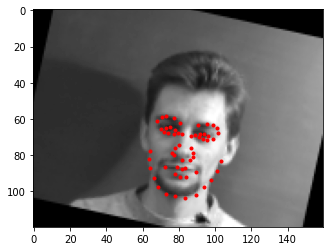

In [ ]:
fig = plt.figure()
i=10
sample = face_dataset[i]
print(i, sample['image'].shape, sample['landmarks'].shape)
show_landmarks(**sample)

In [ ]:
dataloader = DataLoader(face_dataset, batch_size=1, shuffle=False, num_workers=2)

## Sampled image from your dataloader visualized with ground-truth keypoints.

0 torch.Size([1, 120, 160]) torch.Size([1, 58, 2])
1 torch.Size([1, 120, 160]) torch.Size([1, 58, 2])


<Figure size 432x288 with 0 Axes>

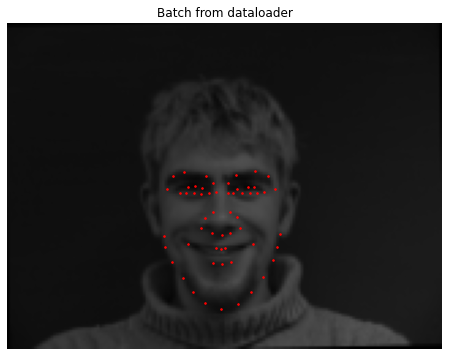

In [ ]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch.unsqueeze(1))
    fig = plt.figure(figsize=(8,6))
    plt.imshow(grid.numpy().transpose((1, 2, 0))+0.5)
    plt.scatter(landmarks_batch[0,:,0].numpy()*images_batch.shape[2],
                    landmarks_batch[0,:,1].numpy()*images_batch.shape[1],
                    s=10, marker='.', c='r')
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 7)
        self.conv2 = nn.Conv2d(12, 16, 6)
        self.conv3 = nn.Conv2d(16, 20, 5)
        self.conv4 = nn.Conv2d(20, 24, 4)
        self.conv5 = nn.Conv2d(24, 28, 3)
        self.fc1 = nn.Linear(28*6*11, 400)
        self.fc2 = nn.Linear(400, 58*2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
final=np.zeros((30,2))
for epoch in range(30):
    running_loss = 0.0
    valid_loss = 0.0
    for i, data in enumerate(dataloader):
      if i<192:
        inputs, labels = data['image'], data['landmarks']
        optimizer.zero_grad()
        outputs = net(inputs.unsqueeze(1).float())
        loss = criterion(outputs.view(-1,58,2), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      else:
        inputs, labels = \
            data['image'], data['landmarks']
        outputs = net(inputs.unsqueeze(1).float())
        loss = criterion(outputs.view(-1,58,2), labels)
        valid_loss += loss.item()
    final[epoch,0]=running_loss/192
    final[epoch,1]=valid_loss/48
    print("Epoch:", epoch)
print('Finished Training')

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Finished Training


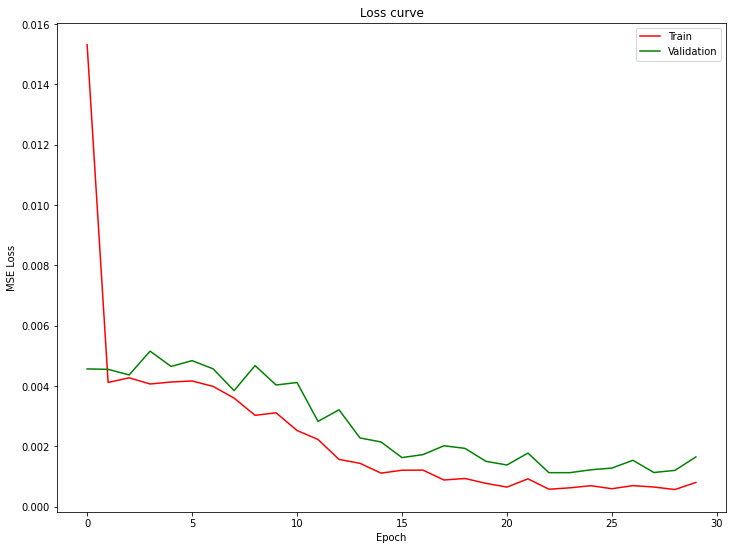

In [ ]:
t1 = np.arange(0.0, 30.0, 1)
plt.figure(figsize=(12,9))
plt.plot(t1, final[:,0], 'r', t1, final[:,1], 'g')
plt.legend(['Train', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Loss curve')
plt.show()

In [ ]:
PATH = '/content/gdrive/My Drive/aleksander_petuskey_proj4/epoch.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

100 torch.Size([120, 160]) torch.Size([58, 2])


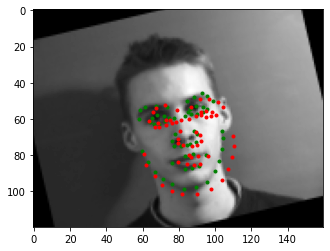

101 torch.Size([120, 160]) torch.Size([58, 2])


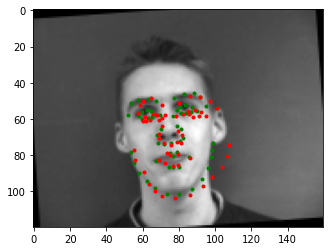

102 torch.Size([120, 160]) torch.Size([58, 2])


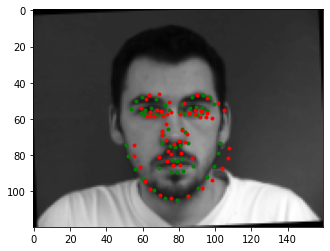

103 torch.Size([120, 160]) torch.Size([58, 2])


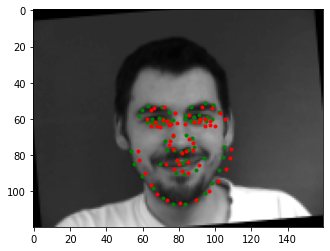

104 torch.Size([120, 160]) torch.Size([58, 2])


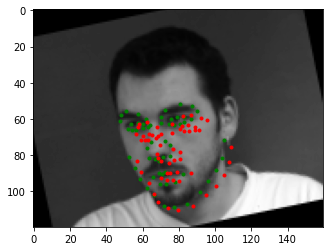

105 torch.Size([120, 160]) torch.Size([58, 2])


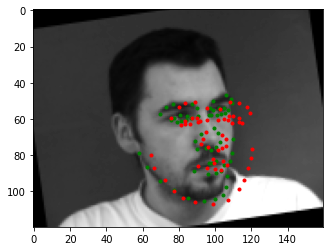

106 torch.Size([120, 160]) torch.Size([58, 2])


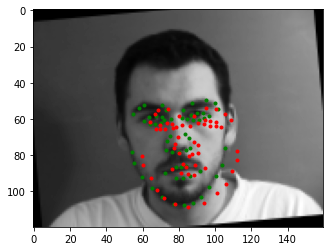

107 torch.Size([120, 160]) torch.Size([58, 2])


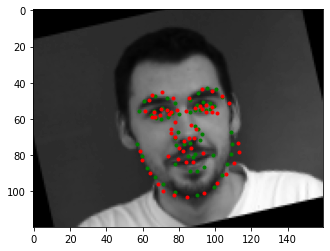

108 torch.Size([120, 160]) torch.Size([58, 2])


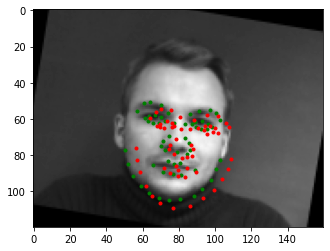

109 torch.Size([120, 160]) torch.Size([58, 2])


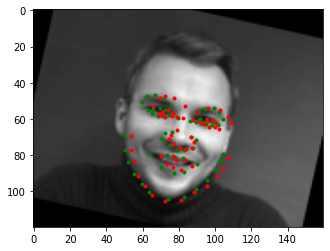

In [ ]:
for i in range(100, 110):
  sample = face_dataset[i]
  print(i, sample['image'].shape, sample['landmarks'].shape)
  image=sample['image']
  landmarks=sample['landmarks']
  outputs = net(image.unsqueeze(0).unsqueeze(0).float())
  outputs = outputs.view(-1,58,2)
  plt.imshow(image, 'gray')
  plt.scatter(image.shape[1]*landmarks[:,0], image.shape[0]*landmarks[:,1], marker='.', c='g')
  plt.scatter(image.shape[1]*outputs.detach().numpy()[0,:,0], image.shape[0]*outputs.detach().numpy()[0,:,1], marker='.', c='r')
  plt.pause(0.001)

# Part 3: Train With Larger Dataset

For this part, we will use a larger dataset, specifically the ibug face in the wild dataset for training a facial keypoints detector. This dataset contains 6666 images of varying image sizes, and each image has 68 annotated facial keypoints. You will need to use Colab with GPU to train the model. As a reference, the staff solution takes 1.5 hours to train 10 epoches using Colab. We provide code to download the dataset and unzip it in Colab.

For our class Kaggle competiton: use this link to download the test set xml file. It contains the image path and face bounding boxes but it does not include the keypoints annotation. You will need to predict the keypoints location and submit the result to Kaggle. Please note (1) Do not use data aguamentation for your test set dataloader (2) You need to convert your keypoint predictions (ratio of width/height in the crop image) to the absolute pixel coodinate in the entire image. (3) Please save all results into one csv file; the csv file should contain 137088 rows (image_0001_keypoints_01_x, image_0001_keypoints_01_y, image_0001_keypoints_02_x, image_0001_keypoints_02_y, ..., image_0001_keypoints_68_x, image_0001_keypoints_68_y, image_0002_keypoints_01_x, image_0002_keypoints_01_y, ...), each with two columns 'Id' and 'Predicted'.

# Dataloader 

In the dataset, the face may occupy only a very small fraction of the entire image (most are the background). During training, we need to crop the image and feed only the face portion. For loading the facial keypoints and the bounding boxes for the face, we have provided example code. You need to use bounding boxes to do the image cropping. Resize the crop into 224x224, and remember to update the keypoints coordinate as well. Use the same data augmentation techniques from part 2. Once you have the dataloader, sample a few images and display them along with the ground-truth keypoints. 

In [ ]:
!wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
!tar -xzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
!rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

--2020-11-10 01:42:29--  http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1798191322 (1.7G) [application/x-gzip]
Saving to: ‘ibug_300W_large_face_landmark_dataset.tar.gz’

ibug_300W_large_fac 100%[===================>]   1.67G  19.6MB/s    in 4m 31s  

2020-11-10 01:47:01 (6.32 MB/s) - ‘ibug_300W_large_face_landmark_dataset.tar.gz’ saved [1798191322/1798191322]



In [ ]:
import os
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
plt.ion() 
import xml.etree.ElementTree as ET 
import numpy as np

In [ ]:
tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = []
landmarks = [] 
img_filenames = []

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')

In [ ]:
def show_landmarks(image, landmark):
    plt.imshow(image, "gray")
    plt.scatter(landmark[:,0], landmark[:,1], marker='.', c='r')

In [ ]:
from helpers import FaceDataset, Rescale, FlipandRotate, ToTensor, FaceDataset2

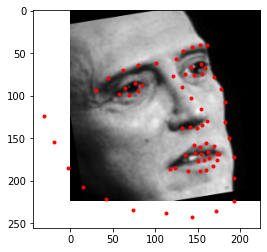

In [ ]:
composed = transforms.Compose([Rescale((224,224)),FlipandRotate(15),ToTensor()])
composed2 = transforms.Compose([transforms.ColorJitter(brightness=0.5)])
face_dataset = FaceDataset(img_filenames,bboxes,landmarks,\
transform=composed,transform2=composed2)
fig = plt.figure()
sample = face_dataset[0]
show_landmarks(**sample)

In [ ]:
dataloader = DataLoader(face_dataset, batch_size=1, shuffle=True, num_workers=4)

0 torch.Size([1, 224, 224]) torch.Size([1, 68, 2])


<Figure size 432x288 with 0 Axes>

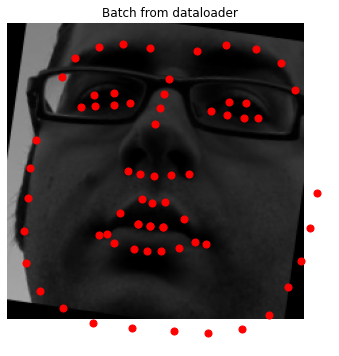

In [ ]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmark']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch.unsqueeze(1))
    fig = plt.figure(figsize=(8,6))
    plt.imshow(grid.numpy().transpose((1, 2, 0))+0.5)
    plt.scatter(landmarks_batch[0,:,0].numpy(),
                    landmarks_batch[0,:,1].numpy(),
                    s=200, marker='.', c='r')
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmark'].size())
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break

In [ ]:
model_ft = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc  = torch.nn.Linear(512, 136, bias=True)
model_ft = model_ft.to(device)
resnet18_criterion = torch.nn.MSELoss()
resnet18_optimizer = torch.optim.Adam(params = model_ft.parameters(), lr = 0.0001)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
from google.colab import files
uploaded= files.upload()

Mounted at /content/gdrive/


In [ ]:
loaded = torch.load('/content/gdrive/My Drive/aleksander_petuskey_proj4/epoch.pth')
model_ft.load_state_dict(loaded )

<All keys matched successfully>

In [ ]:
final=[]
for epoch in range(20): 
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = \
            data['image'], data['landmark']
        inputs, labels = inputs.cuda(), labels.cuda()
        resnet18_optimizer.zero_grad()
        outputs = model_ft(inputs.unsqueeze(1))
        loss = resnet18_criterion(outputs.view(-1,68,2), labels)
        loss.backward()
        resnet18_optimizer.step()
        running_loss += loss.item()
    final.append(running_loss/(i + 1))
    print(i)

6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
6665
Finished Training


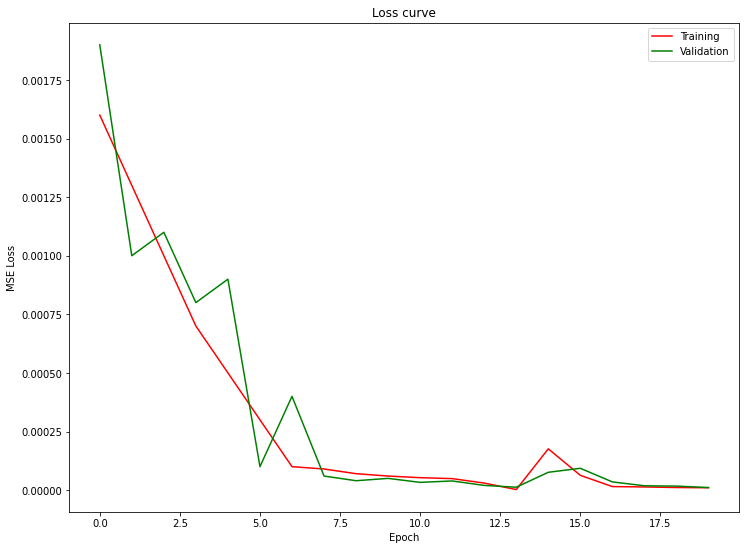

In [ ]:
t1 = np.arange(46, 51, 1.0)
plt.figure(figsize=(12,9))
plt.plot(t1, final[:], 'k')
plt.legend(['Training', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Loss curve')
plt.show()

In [ ]:
!wget https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml
tree2 = ET.parse('/content/labels_ibug_300W_test_parsed.xml')
root2 = tree2.getroot()
root_dir2 = 'ibug_300W_large_face_landmark_dataset'

bboxes2 = [] # face bounding box used to crop the image
img_filenames2 = [] # the image names for the whole dataset

for filename in root2[2]:
	img_filenames2.append(os.path.join(root_dir2, filename.attrib['file']))
	box2 = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes2.append([box2['left'], box2['top'], box2['width'], box2['height']])
     
bboxes2 = np.array(bboxes2).astype('float32')

--2020-11-10 01:50:28--  https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml
Resolving inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)... 128.32.42.199
Connecting to inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)|128.32.42.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131719 (129K) [text/xml]
Saving to: ‘labels_ibug_300W_test_parsed.xml’

labels_ibug_300W_te 100%[===================>] 128.63K   288KB/s    in 0.4s    

2020-11-10 01:50:30 (288 KB/s) - ‘labels_ibug_300W_test_parsed.xml’ saved [131719/131719]



In [ ]:
face_dataset2 = FaceDataset2(img_filenames2,bboxes2)

In [ ]:
def show_landmarks(image, landmark):
    plt.imshow(image, "gray")
    plt.scatter(landmark[:,:,0], landmark[:,:,1], marker='.', c='r')
    plt.pause(0.001)

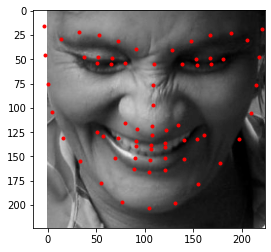

In [ ]:
fig = plt.figure()
i=702
sample = face_dataset2[i]
m=torch.from_numpy(transform.resize(sample['image'],(224,224)))
show_landmarks(m,model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy())

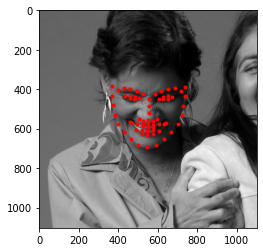

In [ ]:
result=model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy()
image = io.imread(img_filenames2[i])
result[:,:,0]=result[:,:,0]/224*bboxes2[i,3]+int(bboxes2[i,0])
result[:,:,1]=result[:,:,1]/224*bboxes2[i,2]+int(bboxes2[i,1])
plt.imshow(image)
plt.scatter(result[:,:,0], result[:,:,1], marker='.', c='r')